# Introduction : objectives

The quality of data obtained by eddy covariance can be impacted by defavorable meteorological conditions or instrument errors. It then becomes necessary to apply correction operations to reduce uncertainties on carbon fluxes. Based on the standard ICOS procedure, the different post-processing steps are: Quality Check, spike detection, U* filtering and gap-filling.

# Importation of packages and modules

This notebook was developed with:  
- Python 3.13.2  
- Jupyter Notebook  
- Libraries : pandas, numpy, matplotlib, pyjams, hesseflux
- Modules : data_preparation, footprint_analysis
- See 'environment.yml' in the repository for more infos. 

In [94]:
import sys
sys.path.append('/home/jovyan//ICOS-M2-internship-alise/scripts/')

In [95]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import data_preparation as datprep
import footprint_analysis as FFP_analys
import pyjams as pj
import hesseflux as hf
import ustarfilter_hesseflux as ustar_hf

#Pour mettre à jour les modules
import importlib
importlib.reload(datprep)
importlib.reload(FFP_analys)

import watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [96]:
%watermark --iversions

matplotlib: 3.10.1
contextily: 1.6.2
pyjams    : 2.3
hesseflux : 5.0
pandas    : 2.2.3
sys       : 3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:10:22) [GCC 13.3.0]
numpy     : 2.2.4
rasterio  : 1.4.3
watermark : 2.5.0
xarray    : 2025.3.1
rioxarray : 0.19.0



# 1) Data importation and preparation

In [326]:
# Import high frequency data (flux variables) from 2019 to 2024
flux_all = datprep.read_csv_file('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/FR-CLt_*_flux.csv')

In [327]:
# Import low frequency data (meteorological variables) from 2019 to 2024
lofreq_all = datprep.read_csv_file('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/FR-CLt_*_LoFreq.csv', na_values=[-9999.0])

In [328]:
# Standardize the codes of the variable for 2022
flux_all[3] = flux_all[3].rename(columns={'WS_2_1_1': 'WS_1_1_1'})
lofreq_all[3] = lofreq_all[3].rename(columns={'WD_1_1_1': 'WD_2_1_1'})
flux_all[5] = flux_all[5].rename(columns={'CO2_2_1_1': 'CO2_1_1_1'})
flux_all[3] = flux_all[3].drop('WD_2_1_1', axis=1)

In [329]:
# Format time data 
lofreq_all = datprep.prep_timestamp(lofreq_all)
flux_all = datprep.prep_timestamp(flux_all)

In [330]:
# Add wind direction and other meteorological variables to the dataframes
flux_all = datprep.add_lofreqcol(flux_all, lofreq_all, ['WD_2_1_1', 'TA_1_1_1', 'SW_IN_1_1_1', 'RH_1_1_1'])

In [331]:
# Concatenate the flux dataframes
flux_NEE = pd.concat(flux_all, ignore_index=True)

In [332]:
# Put the timestamp in index
flux_NEE = flux_NEE.set_index('TIMESTAMP_START')
flux_NEE = flux_NEE[~flux_NEE.index.duplicated(keep='first')]

In [333]:
# Reindex with one lign every 30 min and complete with NaN for the missing data
full_index = pd.date_range(start=flux_NEE.index.min(), end=flux_NEE.index.max(), freq='30min')
flux_NEE = flux_NEE.reindex(full_index)

In [334]:
# Convert the carbon flux to gC/m2/30 min
flux_NEE['FC_1_1_1'].replace(-9999., np.nan, inplace=True)
flux_NEE['FC_1_1_1'] = flux_NEE['FC_1_1_1'] * 12 / 1e6 * 1800

/tmp/ipykernel_37583/3963424553.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flux_NEE['FC_1_1_1'].replace(-9999., np.nan, inplace=True)


## Add the vapor pressure deficit (VPD) to the dataframe

In [335]:
# Conversion of temperature from °C to K
flux_NEE['TA_1_1_1'].replace(-9999., np.nan, inplace=True)
tk = flux_NEE['TA_1_1_1']+273.15

/tmp/ipykernel_37583/1188017183.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flux_NEE['TA_1_1_1'].replace(-9999., np.nan, inplace=True)


In [336]:
# Conversion of relative humidity to 0. and not %
flux_NEE['RH_1_1_1'].replace(-9999., np.nan, inplace=True)
rh = flux_NEE['RH_1_1_1']/100.

/tmp/ipykernel_37583/1834337769.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flux_NEE['RH_1_1_1'].replace(-9999., np.nan, inplace=True)


In [337]:
# Calculate VPD
vpd = (1. - rh)*pj.esat(tk)
flux_NEE['VPD_1_1_1'] = vpd

# 2) Quality Check (QC)

In [338]:
# Remove data where QC=2 (bad quality according to 2 quality tests)
flux_NEE.loc[flux_NEE['FC_SSITC_TEST_1_1_1'] == 2, 'FC_1_1_1'] = np.nan

# 3) Spike detection

In [339]:
# All NaN values are set to undef and will be ignored in the following
undef = -9999.
flux_NEE.fillna(undef, inplace=True)

In [340]:
# Add a column with "True" when it is night
flux_NEE['TIMESTAMP_START'] = flux_NEE.index.values
flux_NEE['Night'] = flux_NEE['TIMESTAMP_START'].apply(datprep.is_night)

In [341]:
# Create adequate inputs for hesseflux madspikes function
isday = ~flux_NEE['Night'].to_numpy()
C_flux = flux_NEE['FC_1_1_1'].to_frame()

In [342]:
# Create a flag that is not equal to 0 when spikes are detected in the dataset
sflag = hf.madspikes(C_flux, isday=isday, z=5)

In [343]:
# Remove the spikes and keep only the data with sflag=0
despiked_data = flux_NEE.copy()
despiked_data.loc[sflag['FC_1_1_1'] > 0, 'FC_1_1_1'] = np.nan

/tmp/ipykernel_37583/1601778618.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flux_NEE['FC_1_1_1'].replace(-9999., np.nan, inplace=True)


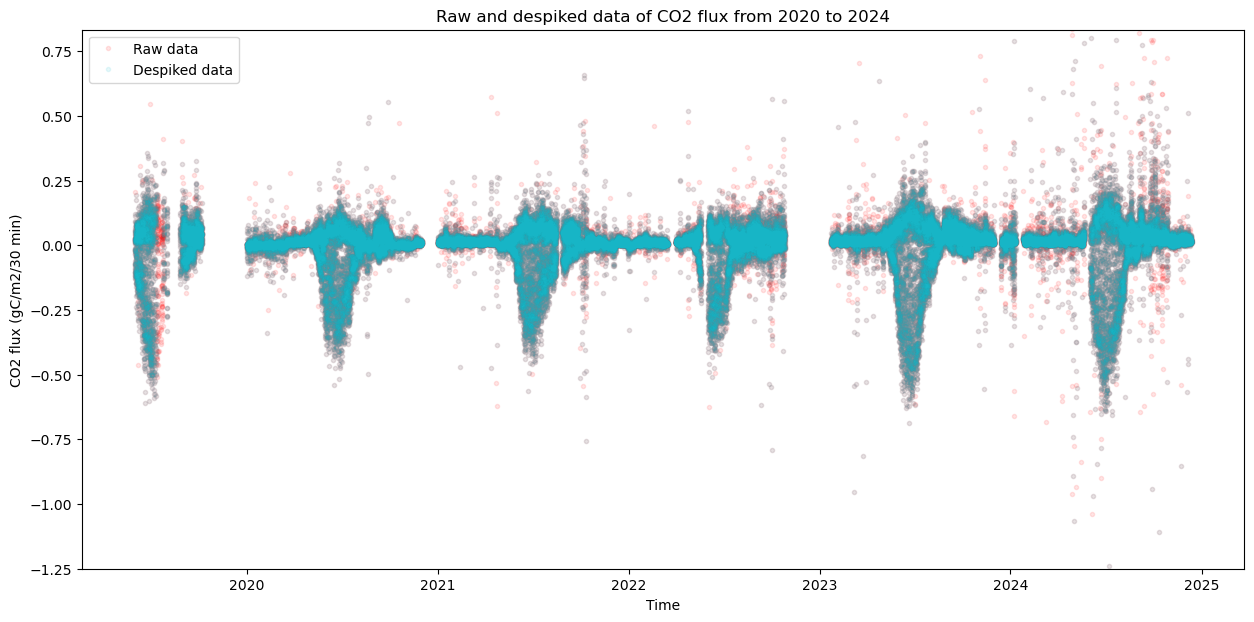

In [344]:
# Plot the raw data VS despiked data
flux_NEE['FC_1_1_1'].replace(-9999., np.nan, inplace=True)

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(flux_NEE['TIMESTAMP_START'], flux_NEE['FC_1_1_1'], '.', color='red', alpha=0.1, label='Raw data')
ax.plot(despiked_data.index.values, despiked_data['FC_1_1_1'], '.', color='tab:cyan', alpha=0.1, label='Despiked data')

ax.set_ylim(-60/48,40/48)

ax.set_xlabel('Time')
ax.set_ylabel('CO2 flux (gC/m2/30 min)')
ax.legend()
plt.title('Raw and despiked data of CO2 flux from 2020 to 2024')
plt.show()

This graph shows the result of spikes removal with Hesseflux "madpikes" function. **There is a lot of missing data for 2019, so for the next steps, only years with more complete and accurate data (2020 to 2024) are kept.**

# 4) u* filtering

In [305]:
# All NaN values are set to undef and will be ignored in the following
undef = -9999.
despiked_data.fillna(undef, inplace=True)

In [318]:
# Delete 2019 data because a lot of missing values
despiked_data_20_24 = despiked_data[despiked_data['TIMESTAMP_START'] >= '2020-01-01']
flux_NEE_20_24 = flux_NEE[flux_NEE['TIMESTAMP_START'] >= '2020-01-01']

In [310]:
# Create adequate inputs for hesseflux ustarfilter function
isday = ~despiked_data_20_24['Night'].to_numpy()

In [311]:
# Create a flag that is equal to 2 when u* is too low
ustars, flag_u = ustar_hf.ustarfilter(despiked_data_20_24[['FC_1_1_1', 'USTAR_1_1_1', 'TA_1_1_1']], isday=isday, ustarmin=0.01)

In [312]:
flag_u.value_counts()

USTAR_1_1_1
0    49879
2    36905
Name: count, dtype: int64

In [313]:
# Keep only the data with uflag=0
filtered_data = despiked_data_20_24.copy()
filtered_data.loc[flag_u > 0, 'FC_1_1_1'] = np.nan

/tmp/ipykernel_37583/1831037092.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_data['FC_1_1_1'].replace(-9999., np.nan, inplace=True)


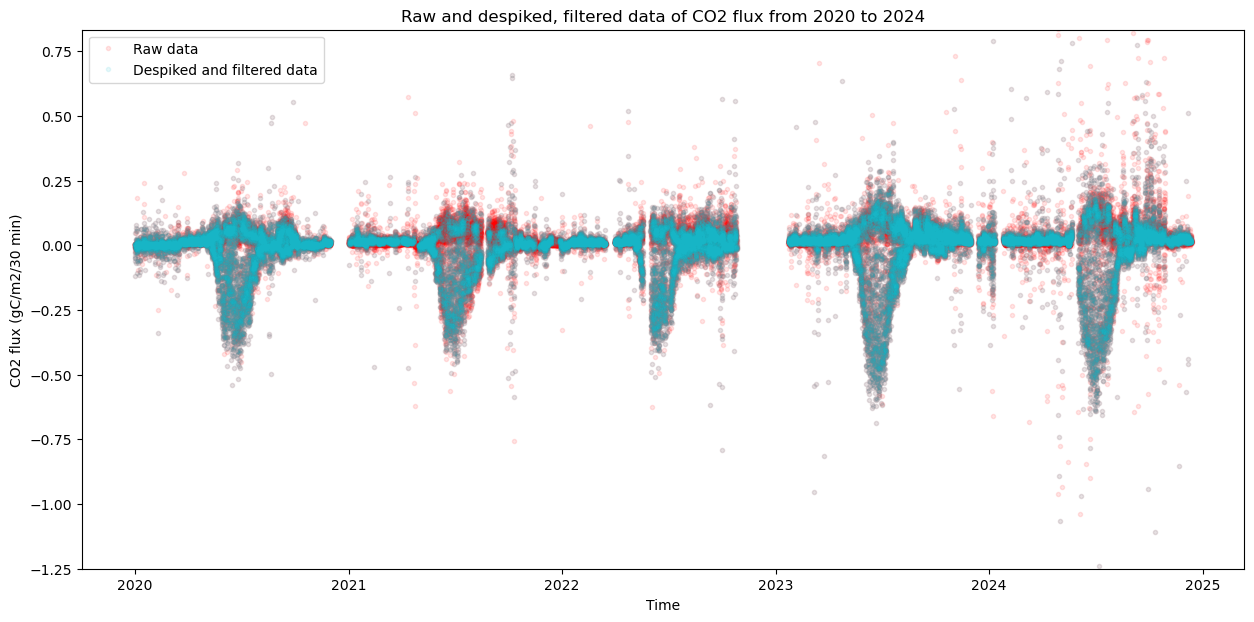

In [314]:
# Plot the raw data VS despiked + ustar filtered data
filtered_data['FC_1_1_1'].replace(-9999., np.nan, inplace=True)

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(flux_NEE_20_24['TIMESTAMP_START'], flux_NEE_20_24['FC_1_1_1'], '.', color='red', alpha=0.1, label='Raw data')
ax.plot(filtered_data.index.values, filtered_data['FC_1_1_1'], '.', color='tab:cyan', alpha=0.1, label='Despiked and filtered data')

ax.set_ylim(-60/48,40/48)

ax.set_xlabel('Time')
ax.set_ylabel('CO2 flux (gC/m2/30 min)')
ax.legend()
plt.title('Raw and despiked, filtered data of CO2 flux from 2020 to 2024')
plt.show()

This graph shows the result of u* filtering with Hesseflux "ustarfilter" function.

# 5) Gap-filling

In [315]:
# All NaN values are set to undef and will be ignored in the following
undef = -9999.
filtered_data.fillna(undef, inplace=True)

In [316]:
# Gapfill the missing values with Reichstein method
gapfill, flag_gf = hf.gapfill(filtered_data[['SW_IN_1_1_1', 'TA_1_1_1', 'VPD_1_1_1', 'FC_1_1_1']])

/tmp/ipykernel_37583/1455897749.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gapfill['FC_1_1_1'].replace(-9999., np.nan, inplace=True)


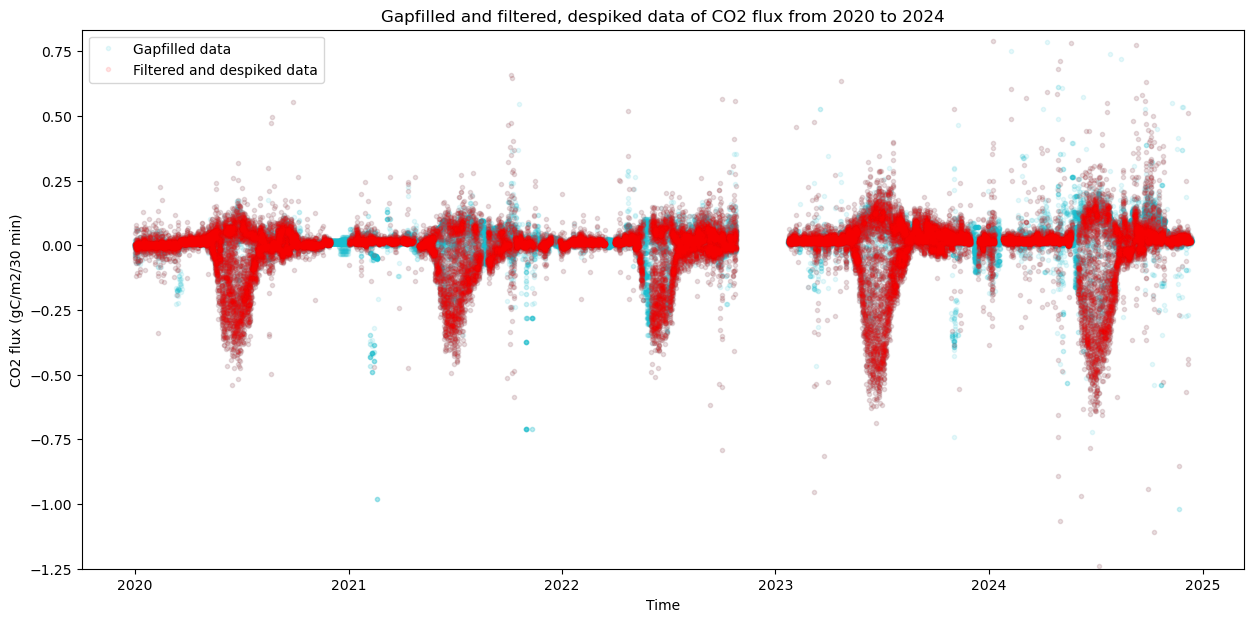

In [317]:
# Plot the filtered data VS filtered + gapfilled data
gapfill['FC_1_1_1'].replace(-9999., np.nan, inplace=True)

# Plot the filtered data VS filtered + gapfilled data
fig, ax = plt.subplots(figsize=(15,7))

ax.plot(gapfill.index.values, gapfill['FC_1_1_1'], '.', color='tab:cyan', alpha=0.1, label='Gapfilled data')
ax.plot(filtered_data['TIMESTAMP_START'], filtered_data['FC_1_1_1'], '.', color='red', alpha=0.1, label='Filtered and despiked data')

ax.set_ylim(-60/48,40/48)

ax.set_xlabel('Time')
ax.set_ylabel('CO2 flux (gC/m2/30 min)')
ax.legend()
plt.title('Gapfilled and filtered, despiked data of CO2 flux from 2020 to 2024')
plt.show()

This graph shows the periods gapfilled with Reichstein method. The next step will be to calculate what exact proportion of data has been filtered or gapfilled.

In [319]:
# Calculate the total number of dates
n = len(gapfill)
n

86784

In [322]:
# Proportion of available values in the raw flux
(n-flux_NEE_20_24['FC_1_1_1'].isna().sum())/n

np.float64(0.7514749262536873)

In [323]:
# Proportion of available values after despiking and filtering steps
filtered_data['FC_1_1_1'].replace(-9999., np.nan, inplace=True)
(n-filtered_data['FC_1_1_1'].isna().sum())/n

/tmp/ipykernel_37583/252242577.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_data['FC_1_1_1'].replace(-9999., np.nan, inplace=True)


np.float64(0.4645441556047198)

In [324]:
# Proportion of available values after gapfilling
(n-gapfill['FC_1_1_1'].isna().sum())/n

np.float64(0.9509702249262537)

**The percentage of available half-hourly values from 2020 to 2024 goes from 75% for raw data to 46% after filtering, reaching 95% after gap-filling.**

### Save the filtered data as a csv file

In [325]:
filtered_data.to_csv('filtered_data.csv', index=False)

# Conclusion

Following this post-processing, only the most reliable flux values are retained for further analysis. A large proportion of the data is discarded: the percentage of available values drops from 75% to 46% after filtering. The gap-filling step is useful for estimating long-term budgets and daily trends,  as it allows the annual cycle of the ecosystem to be estimated with 95% of the values. However, this step relies on interpolation from actually measured data, so it should be considered with caution. **As 2019 suffers from significant lack of data, it will not be taken into account for the calculation of annual budgets and for flux partitioning. For the following analyses, only filtered data will be studied.**